###Alumna Farinazzo Analia 24994389@ifts24.edu.ar

### Laboratorio Integrador 2

En esta actividad, vamos a poner en práctica todo lo que aprendimos sobre procesamiento de imágenes para crear un proyecto.

Objetivo: El objetivo de este proyecto es que utilicen procedimientos básicos de procesamiento de imágenes para leer una imagen, aplicarle mejoras, segmentar objetos y mostrar los resultados en una presentación visual.

Duración: Tenemos 1 hora para completar este desafío.

##Preparación:

Entorno: Vamos a usar Google Colab, que ya tiene todo lo que necesitamos instalado.

##Imágenes:

Les voy a proporcionar un conjunto de imágenes de ejemplo para que elijan la que más les guste. Hay de todo un poco: paisajes, objetos, retratos... ¡para que tengan variedad!

Si prefieren, ¡pueden usar sus propias fotos! Solo recuerden elegir una imagen con buena iluminación y calidad para que los resultados sean los mejores.

Google Colab: Este cuaderno ya está listo para que trabajen. Solo tienen que seguir las instrucciones y completar el código en los espacios indicados.

Pasos a seguir:

##1. ¡Empecemos importando las bibliotecas!
Lo primero que vamos a hacer es importar las herramientas que vamos a utilizar.

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from google.colab.patches import cv2_imshow

## 2. Leyendo y viendo nuestra imagen
Subir la imagen: Si van a usar una foto propia, súbanla a Google Colab. Para hacerlo, hagan clic en el ícono de la carpeta en la barra lateral izquierda, luego en el ícono de "Subir" y seleccionen su archivo.

Leer la imagen: Con cv2.imread(), vamos a leer la imagen que eligieron. Recuerden que OpenCV lee las imágenes en formato BGR, así que la vamos a convertir a RGB para poder verla bien con Matplotlib.

Mostrar la imagen original: Usaremos matplotlib.pyplot para ver la imagen tal como es al principio.

In [3]:
!wget http://farm9.staticflickr.com/8087/8482029576_14a49700d4_z.jpg -O imagen_lab2.jpg

--2025-05-13 01:28:50--  http://farm9.staticflickr.com/8087/8482029576_14a49700d4_z.jpg
Resolving farm9.staticflickr.com (farm9.staticflickr.com)... 18.160.140.81, 2600:9000:24ce:3600:0:5a51:64c9:c681, 2600:9000:24ce:600:0:5a51:64c9:c681, ...
Connecting to farm9.staticflickr.com (farm9.staticflickr.com)|18.160.140.81|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://farm9.staticflickr.com/8087/8482029576_14a49700d4_z.jpg [following]
--2025-05-13 01:28:50--  https://farm9.staticflickr.com/8087/8482029576_14a49700d4_z.jpg
Connecting to farm9.staticflickr.com (farm9.staticflickr.com)|18.160.140.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘imagen_lab2.jpg’

imagen_lab2.jpg         [ <=>                ]  51.02K  --.-KB/s    in 0.01s   

2025-05-13 01:28:51 (4.55 MB/s) - ‘imagen_lab2.jpg’ saved [52249]



####Elegimos esta imagen porque nos gustó la combinación de colores y el contraste, además estaban las frutas bien separadas para que la segmentación sea más clara.

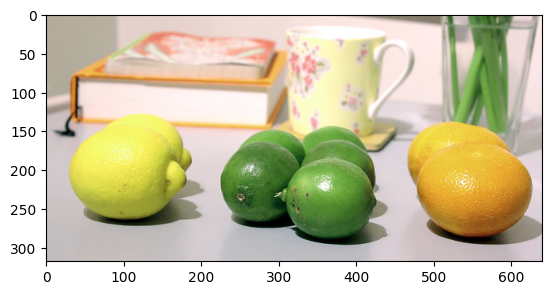

In [4]:
img = cv2.imread('imagen_lab2.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##3. ¡Mejorando nuestra imagen!
Ahora vamos a aplicar un par de técnicas para que nuestra imagen se vea aún mejor:

Ajuste de brillo y contraste: Vamos a crear una función para modificar estos aspectos de la imagen.

Ecualización de histograma: Con cv2.equalizeHist(), vamos a mejorar el contraste de la imagen.

In [6]:
K = img.copy()  # Hacer una copia de la imagen original
Khsv = cv2.cvtColor(K, cv2.COLOR_BGR2HSV)  # Convertir a HSV
Khsv[:, :, 2] = cv2.equalizeHist(Khsv[:, :, 2])  # Ecualizar el canal de brillo (V)
Knew = cv2.cvtColor(Khsv, cv2.COLOR_HSV2BGR)  # Convertir de nuevo a BGR

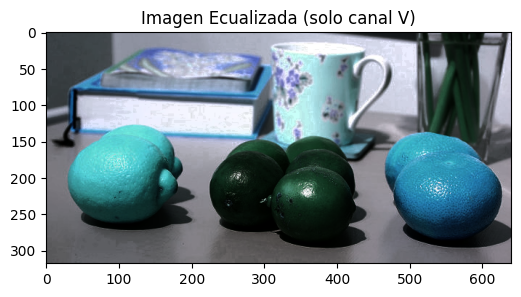

In [7]:
plt.figure(figsize=(6, 9))  # Tamaño de la figura
plt.imshow(cv2.cvtColor(Knew, cv2.COLOR_BGR2RGB))  # Mostrar la imagen ecualizada
plt.title('Imagen Ecualizada (solo canal V)')  # Título
plt.show()  # Mostrar figura

##4. ¡A segmentar por color!
Ahora viene una parte muy interesante: vamos a separar objetos de la imagen por su color.

Convertir a HSV: Vamos a pasar la imagen de RGB a HSV (Hue, Saturation, Value) porque es más fácil definir rangos de color en HSV.

Definir el rango de color: Vamos a establecer los límites inferior y superior del color que queremos segmentar. En el ejemplo, segmentamos el color rojo de las flores. ¡Presten mucha atención acá! Van a tener que ajustar estos valores para su propia imagen.

Crear una máscara: Con cv2.inRange(), vamos a crear una máscara que nos indique qué píxeles están dentro del rango de color y cuáles no.

Aplicar la máscara: Usaremos cv2.bitwise_and() para quedarnos solo con la parte de la imagen que corresponde al color que elegimos.

In [8]:
import ipywidgets as widgets
from IPython.display import display

# Estoy explorando este codigo recomendado por Gemini para obtener los umbrales de color de una forma más
# interactiva.  Creo que es una evolución de la que en su momentos nos presentó Martín.
# Este código nos permite detectar los umbrales y combinar los diferentes canales de tal manera de generar una máscara lo más depurada posible.
# Para chusmear no solo lo hice para el espacio HSV, sino también para el BGR.

# Variables globales
imagen_original = None
imagen_mask_bgr_widget = None
imagen_mask_hsv_widget = None
texto_umbrales_bgr = None
texto_umbrales_hsv = None

def actualizar_mask_con_visualizacion_organizada(h_min, h_max, s_min, s_max, v_min, v_max,
                                                    b_min, b_max, g_min, g_max, r_min, r_max,
                                                    check_h, check_s, check_v,
                                                    check_b, check_g, check_r):
    global imagen_original, imagen_mask_bgr_widget, imagen_mask_hsv_widget, texto_umbrales_bgr, texto_umbrales_hsv, imagen_resultante_bgr, imagen_resultante_hsv, mask_hsv_global


    lower_bgr = np.array([0, 0, 0])
    upper_bgr = np.array([255, 255, 255])
    hsv = cv2.cvtColor(imagen_original, cv2.COLOR_BGR2HSV)
    lower_hsv = np.array([0, 0, 0])
    upper_hsv = np.array([179, 255, 255])

    if check_b:
        lower_bgr[0] = b_min
        upper_bgr[0] = b_max
    if check_g:
        lower_bgr[1] = g_min
        upper_bgr[1] = g_max
    if check_r:
        lower_bgr[2] = r_min
        upper_bgr[2] = r_max

    mask_bgr = cv2.inRange(imagen_original, lower_bgr, upper_bgr)
    result_bgr = cv2.bitwise_and(imagen_original, imagen_original, mask=mask_bgr)

    if check_h:
        lower_hsv[0] = h_min
        upper_hsv[0] = h_max
    else:
        upper_hsv[0] = 179
    if check_s:
        lower_hsv[1] = s_min
        upper_hsv[1] = s_max
    else:
        upper_hsv[1] = 255
    if check_v:
        lower_hsv[2] = v_min
        upper_hsv[2] = v_max
    else:
        upper_hsv[2] = 255

    mask_hsv = cv2.inRange(hsv, lower_hsv, upper_hsv)
    result_hsv = cv2.bitwise_and(imagen_original, imagen_original, mask=mask_hsv)

    imagen_resultante_bgr = result_bgr.copy()
    imagen_resultante_hsv = result_hsv.copy()
    mask_hsv_global = mask_hsv.copy()

    # Convertir las imágenes a formato compatible con display
    _, result_bgr_display = cv2.imencode('.png', result_bgr)
    _, result_hsv_display = cv2.imencode('.png', result_hsv)

    imagen_mask_bgr_widget.value = result_bgr_display.tobytes()
    imagen_mask_hsv_widget.value = result_hsv_display.tobytes()

    texto_umbrales_bgr.value = f"""
    **Umbrales BGR:**<br>
    Bajo: [{lower_bgr[0]}, {lower_bgr[1]}, {lower_bgr[2]}]<br>
    Alto:  [{upper_bgr[0]}, {upper_bgr[1]}, {upper_bgr[2]}]
    """

    texto_umbrales_hsv.value = f"""
    **Umbrales HSV:**<br>
    Bajo: [{lower_hsv[0]}, {lower_hsv[1]}, {lower_hsv[2]}]<br>
    Alto:  [{upper_hsv[0]}, {upper_hsv[1]}, {upper_hsv[2]}]
    """

def main_visual_organizada():
    global imagen_original, imagen_mask_bgr_widget, imagen_mask_hsv_widget, texto_umbrales_bgr, texto_umbrales_hsv
    ruta_imagen = "imagen_lab2.jpg"

    imagen_original = cv2.imread(ruta_imagen)
    if imagen_original is None:
        print(f"No se pudo cargar la imagen: {ruta_imagen}")
        return

    # Widgets de imagen con títulos
    titulo_bgr = widgets.Label(value="**Resultado BGR**")
    imagen_mask_bgr_widget = widgets.Image(format='png')
    titulo_hsv = widgets.Label(value="**Resultado HSV**")
    imagen_mask_hsv_widget = widgets.Image(format='png')

    # Controles BGR
    check_blue = widgets.Checkbox(value=True, description='Usar Blue')
    blue_min_slider = widgets.IntSlider(min=0, max=255, value=0, description='Blue Min')
    blue_max_slider = widgets.IntSlider(min=0, max=255, value=255, description='Blue Max')
    check_green = widgets.Checkbox(value=True, description='Usar Green')
    green_min_slider = widgets.IntSlider(min=0, max=255, value=0, description='Green Min')
    green_max_slider = widgets.IntSlider(min=0, max=255, value=255, description='Green Max')
    check_red = widgets.Checkbox(value=True, description='Usar Red')
    red_min_slider = widgets.IntSlider(min=0, max=255, value=0, description='Red Min')
    red_max_slider = widgets.IntSlider(min=0, max=255, value=255, description='Red Max')

    controles_bgr = widgets.VBox([check_blue, blue_min_slider, blue_max_slider,
                                   check_green, green_min_slider, green_max_slider,
                                   check_red, red_min_slider, red_max_slider])
    titulo_controles_bgr = widgets.Label(value="**Controles BGR**")
    columna_bgr = widgets.VBox([titulo_bgr, imagen_mask_bgr_widget, titulo_controles_bgr, controles_bgr])

    # Controles HSV
    check_hue = widgets.Checkbox(value=True, description='Usar Hue')
    hue_min_slider = widgets.IntSlider(min=0, max=179, value=0, description='Hue Min')
    hue_max_slider = widgets.IntSlider(min=0, max=179, value=179, description='Hue Max')
    check_saturation = widgets.Checkbox(value=True, description='Usar Saturation')
    sat_min_slider = widgets.IntSlider(min=0, max=255, value=0, description='Sat Min')
    sat_max_slider = widgets.IntSlider(min=0, max=255, value=255, description='Sat Max')
    check_value = widgets.Checkbox(value=True, description='Usar Value')
    val_min_slider = widgets.IntSlider(min=0, max=255, value=0, description='Val Min')
    val_max_slider = widgets.IntSlider(min=0, max=255, value=255, description='Val Max')

    controles_hsv = widgets.VBox([check_hue, hue_min_slider, hue_max_slider,
                                   check_saturation, sat_min_slider, sat_max_slider,
                                   check_value, val_min_slider, val_max_slider])
    titulo_controles_hsv = widgets.Label(value="**Controles HSV**")
    columna_hsv = widgets.VBox([titulo_hsv, imagen_mask_hsv_widget, titulo_controles_hsv, controles_hsv])

    # Mostrar las columnas en paralelo
    display(widgets.HBox([columna_bgr, columna_hsv]))

    # Widgets para mostrar los umbrales debajo de cada columna
    texto_umbrales_bgr = widgets.HTML(value="""**Umbrales BGR:**<br>Bajo: [0, 0, 0]<br>Alto:  [255, 255, 255]""")
    texto_umbrales_hsv = widgets.HTML(value="""**Umbrales HSV:**<br>Bajo: [0, 0, 0]<br>Alto:  [179, 255, 255]""")

    display(widgets.HBox([widgets.VBox([widgets.Label(value="**Umbrales BGR**"), texto_umbrales_bgr]),
                           widgets.VBox([widgets.Label(value="**Umbrales HSV**"), texto_umbrales_hsv])]))

    # Función de actualización
    def on_widget_change_organizada(change):
        actualizar_mask_con_visualizacion_organizada(hue_min_slider.value, hue_max_slider.value,
                                                       sat_min_slider.value, sat_max_slider.value,
                                                       val_min_slider.value, val_max_slider.value,
                                                       blue_min_slider.value, blue_max_slider.value,
                                                       green_min_slider.value, green_max_slider.value,
                                                       red_min_slider.value, red_max_slider.value,
                                                       check_hue.value, check_saturation.value, check_value.value,
                                                       check_blue.value, check_green.value, check_red.value)

    # Observadores para todos los widgets
    # ... (los mismos observadores que antes)
    hue_min_slider.observe(on_widget_change_organizada, names='value')
    hue_max_slider.observe(on_widget_change_organizada, names='value')
    sat_min_slider.observe(on_widget_change_organizada, names='value')
    sat_max_slider.observe(on_widget_change_organizada, names='value')
    val_min_slider.observe(on_widget_change_organizada, names='value')
    val_max_slider.observe(on_widget_change_organizada, names='value')
    check_hue.observe(on_widget_change_organizada, names='value')
    check_saturation.observe(on_widget_change_organizada, names='value')
    check_value.observe(on_widget_change_organizada, names='value')
    blue_min_slider.observe(on_widget_change_organizada, names='value')
    blue_max_slider.observe(on_widget_change_organizada, names='value')
    green_min_slider.observe(on_widget_change_organizada, names='value')
    green_max_slider.observe(on_widget_change_organizada, names='value')
    red_min_slider.observe(on_widget_change_organizada, names='value')
    red_max_slider.observe(on_widget_change_organizada, names='value')
    check_blue.observe(on_widget_change_organizada, names='value')
    check_green.observe(on_widget_change_organizada, names='value')
    check_red.observe(on_widget_change_organizada, names='value')

    # Mostrar la máscara inicial
    on_widget_change_organizada(None)

if __name__ == "__main__":
    main_visual_organizada()

##5. ¡Dibujando y escribiendo sobre la imagen!
Para terminar, vamos a agregarle un poco de información a nuestra imagen segmentada.

Dibujar rectángulos: Con cv2.findContours() vamos a encontrar los contornos de los objetos que segmentamos, y con cv2.boundingRect() vamos a obtener las coordenadas para dibujar un rectángulo alrededor de ellos. Usaremos cv2.rectangle() para dibujar el rectángulo.

Agregar texto: Con cv2.putText(), vamos a agregar un texto que describa los objetos que segmentamos.

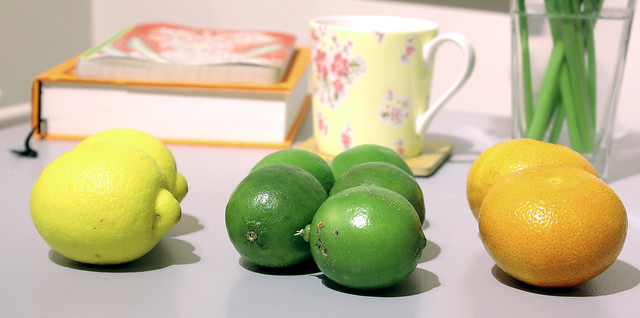

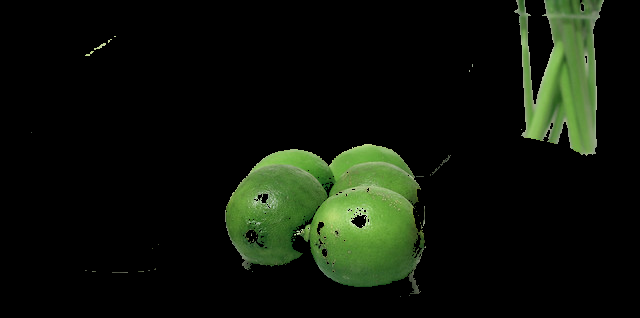

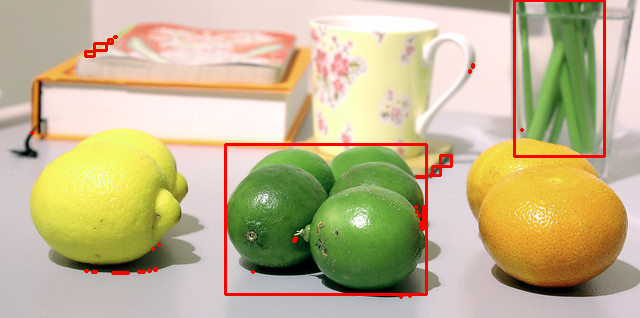

In [26]:
#Explorando la deteccion automática de los contornos.

def dibujar_rectangulos(imagen_original, mascara):
    # 1. Encontrar los contornos
    # Necesitamos una imagen binaria para findContours. La máscara ya lo es (blanco donde hay objeto, negro donde no).
    # cv2.RETR_EXTERNAL: Obtiene solo los contornos externos.
    # cv2.CHAIN_APPROX_SIMPLE: Comprime los segmentos horizontales, verticales y diagonales en sus puntos finales.
    contornos, _ = cv2.findContours(mascara, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Crear una copia de la imagen original para dibujar los rectángulos sobre ella
    imagen_con_rectangulos = imagen_original.copy()

    # 2. Iterar sobre los contornos encontrados
    for contorno in contornos:
        # 3. Obtener las coordenadas del rectángulo delimitador
        x, y, w, h = cv2.boundingRect(contorno)

        # 4. Dibujar el rectángulo en la imagen
        # color: (B, G, R) - elige el color que quieras para el rectángulo
        color_rectangulo = (0, 0, 255)  # Verde
        grosor_linea = 2
        cv2.rectangle(imagen_con_rectangulos, (x, y), (x + w, y + h), color_rectangulo, grosor_linea)

    return imagen_con_rectangulos

def main_dibujar_contornos():
    global g_imagen_seg
    ruta_imagen = "imagen_lab2.jpg"  # Reemplaza con la ruta de tu imagen
    imagen_original = cv2.imread(ruta_imagen)

    if imagen_original is None:
        print(f"No se pudo cargar la imagen: {ruta_imagen}")
        return

    # Aplicar la máscara (opcional, solo para visualizar la segmentación)
    imagen_segmentada = imagen_resultante_hsv
    g_imagen_seg = imagen_segmentada.copy()

    # Dibujar los rectángulos alrededor de los objetos detectados en la máscara
    imagen_con_rectangulos = dibujar_rectangulos(imagen_original.copy(), mask_hsv_global)

    # Mostrar las imágenes
    cv2_imshow(imagen_original)
    cv2_imshow(imagen_segmentada)
    cv2_imshow(imagen_con_rectangulos)


if __name__ == "__main__":
    main_dibujar_contornos()


Nota mental:  Usar métodos de limpieza para pixeles sueltos, así disminuye la cantidad de rectángulos a mostrar.

Agregado, buscando que sea más prolija la detección de los objetos color verde que son los que aspirábamos segmentar.
Reutilizo código de un tratamiento de imagen hecho previamente.

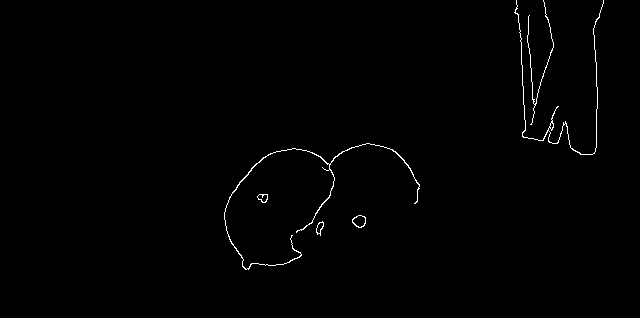

In [38]:
def obtener_borde_limpio_canny(imagen_gris):
    # 1. Aplicar un filtro Gaussiano para reducir el ruido
    # El kernel_size (3x3 en este caso) y sigmaX (desviación estándar en dirección X)
    # son parámetros que puedes ajustar según el nivel de ruido en tu imagen.
    imagen_suavizada = cv2.GaussianBlur(imagen_gris, (9, 11), 0)


    # 2. Aplicar el detector de bordes Canny
    # Los parámetros threshold1 y threshold2 son los umbrales inferior y superior, respectivamente.
    # Un borde se considera "fuerte" si su gradiente es mayor que threshold2, y se incluye directamente.
    # Un borde se considera "débil" si su gradiente está entre threshold1 y threshold2. Los bordes débiles
    # se incluyen solo si están conectados a un borde fuerte.
    # Puedes experimentar con estos valores para obtener el mejor resultado para tus imágenes.
    bordes_canny = cv2.Canny(imagen_suavizada, 50, 300)

    return bordes_canny

# Ejemplo de uso:
if __name__ == '__main__':
    # Cargar tu imagen
    imagen_original = g_imagen_seg

    # Convertir a escala de grises
    imagen_gris = cv2.cvtColor(imagen_original, cv2.COLOR_BGR2GRAY)

    # Obtener el borde limpio usando Canny
    borde_limpio = obtener_borde_limpio_canny(imagen_gris)

    # Mostrar la imagen original y el borde detectado
    cv2_imshow(borde_limpio)



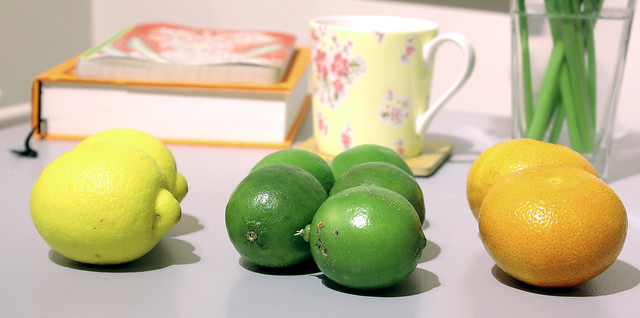

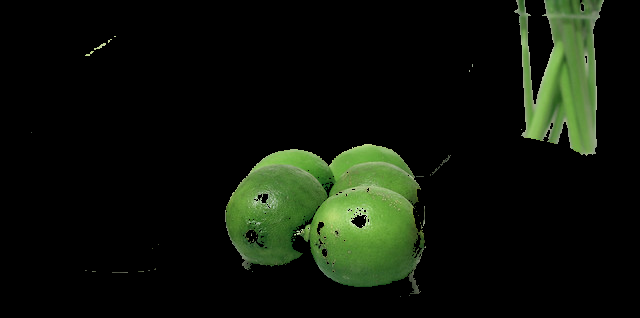

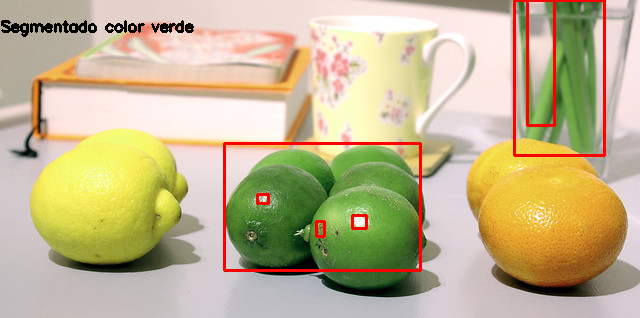

In [48]:
#Explorando la deteccion automática de los contornos.

def dibujar_rectangulos(imagen_original, mascara):
    # 1. Encontrar los contornos
    # Necesitamos una imagen binaria para findContours. La máscara ya lo es (blanco donde hay objeto, negro donde no).
    # cv2.RETR_EXTERNAL: Obtiene solo los contornos externos.
    # cv2.CHAIN_APPROX_SIMPLE: Comprime los segmentos horizontales, verticales y diagonales en sus puntos finales.
    contornos, _ = cv2.findContours(mascara, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Crear una copia de la imagen original para dibujar los rectángulos sobre ella
    imagen_con_rectangulos = imagen_original.copy()

    # 2. Iterar sobre los contornos encontrados
    for contorno in contornos:
        # 3. Obtener las coordenadas del rectángulo delimitador
        x, y, w, h = cv2.boundingRect(contorno)

        # 4. Dibujar el rectángulo en la imagen
        # color: (B, G, R) - elige el color que quieras para el rectángulo
        color_rectangulo = (0, 0, 255)  # Verde
        grosor_linea = 2
        cv2.rectangle(imagen_con_rectangulos, (x, y), (x + w, y + h), color_rectangulo, grosor_linea)

    return imagen_con_rectangulos

def main_dibujar_contornos():
    global g_imagen_seg
    ruta_imagen = "imagen_lab2.jpg"  # Reemplaza con la ruta de tu imagen
    imagen_original = cv2.imread(ruta_imagen)

    if imagen_original is None:
        print(f"No se pudo cargar la imagen: {ruta_imagen}")
        return

    # Aplicar la máscara (opcional, solo para visualizar la segmentación)
    imagen_segmentada = imagen_resultante_hsv
    g_imagen_seg = imagen_segmentada.copy()

    # Dibujar los rectángulos alrededor de los objetos detectados en la máscara
    imagen_con_rectangulos = dibujar_rectangulos(imagen_original.copy(), borde_limpio)

    # Mostrar las imágenes
    cv2_imshow(imagen_original)
    cv2_imshow(imagen_segmentada)

    #Vamos a encontrar las coordenas del objeto para poder delimitarlo.

    (N,M) = imagen_segmentada.shape[:2]
    i_min = 6000
    i_max = 1
    j_min = 6000
    j_max = 1

    for i in range(N):
      for j in range(M):
          if (imagen_segmentada[i, j] > 0).any():
            if i<i_min: i_min = i
            if i>i_max: i_max = i
            if j<j_min: j_min = j
            if j>j_max: j_max = j

    # Dibujo del rectángulo
    y = [i_min,i_min,i_max,i_max,i_min]
    x = [j_min,j_max,j_max,j_min,j_min]

    cv2.putText(imagen_con_rectangulos, "Segmentado color verde", (i_min,j_min ), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)
    cv2_imshow(imagen_con_rectangulos)


if __name__ == "__main__":
    main_dibujar_contornos()



##6. Presentaciones preliminares

Cada uno/una de ustedes va a tener 5 minutos para mostrarnos su trabajo, que debe incluir:

La imagen original.

La imagen mejorada (ya sea con ajuste de brillo/contraste o ecualización de histograma).

La imagen segmentada.

Una explicación de todo el proceso, incluyendo:

La imagen que eligieron y por qué.

Los valores que usaron para ajustar el brillo y el contraste (si lo hicieron).

El rango de color HSV que eligieron para segmentar y por qué.

Cualquier dificultad que hayan tenido y cómo la resolvieron.

## Recursos

### Datasets Generales:

**[COCO](https://cocodataset.org/) (Common Objects in Context):** Este dataset es muy completo, con imágenes de objetos cotidianos en escenas complejas. Es ideal para practicar segmentación y reconocimiento de objetos.

**Ideas para el proyecto:** Segmentar diferentes objetos en una escena (personas, autos, animales) y analizar sus relaciones espaciales.


**[Open Images](https://storage.googleapis.com/openimages/web/index.html):** Un dataset masivo con millones de imágenes y anotaciones de objetos. Ofrece una gran variedad de temas y es excelente para proyectos más ambiciosos.

**Ideas para el proyecto:** Detectar y segmentar múltiples objetos en una imagen, o incluso intentar segmentar objetos dentro de un contexto específico (por ejemplo, segmentar diferentes tipos de árboles en un paisaje).


**[ImageNet](https://www.image-net.org/):** Este dataset contiene una gran cantidad de imágenes organizadas según la jerarquía de WordNet.

**Ideas para el Proyecto:** Los estudiantes pueden usar un subconjunto de ImageNet para segmentar y clasificar diferentes categorías de imágenes, como animales, vehículos o plantas.


### Datasets Específicos:

**[Flores](https://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html):** Datasets como Oxford Flowers 102 son perfectos para proyectos de segmentación por color, donde los estudiantes pueden aislar flores de diferentes tipos y colores.

**Ideas para el proyecto:** Segmentar flores de un color específico y luego usar técnicas de procesamiento de imágenes para analizar su forma o textura.


**[Rostros](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html):** Datasets como CelebA pueden usarse para proyectos de segmentación de características faciales o reconocimiento de rostros.

**Ideas para el proyecto:** Segmentar diferentes partes del rostro (ojos, nariz, boca) y analizar cómo cambian con las expresiones faciales.


**[Paisajes Urbanos](https://www.cityscapes-dataset.com/):** Cityscapes es ideal para segmentar elementos en entornos urbanos, como autos, peatones y edificios.

### Dónde Encontrar Más Datasets:

**[Kaggle](https://www.kaggle.com/datasets?search=image):** Esta plataforma ofrece una gran variedad de datasets de imágenes subidos por la comunidad, que pueden ser útiles para proyectos específicos.


**[Papers With Code](https://paperswithcode.com/datasets?mod=images):** Este sitio web recopila datasets utilizados en investigaciones de aprendizaje automático, incluyendo muchos datasets de imágenes.
Usa el código con precaución